<a href="https://colab.research.google.com/github/Yogesh-8998/Energy-Appliances-Prediction/blob/main/Appliances_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes (parameters).

#Data Description

date time year-month-day hour:minute:second

date - time year-month-day hour:minute:second

Appliances - energy use in Wh (Dependent variable)

lights - energy use of light fixtures in the house in Wh (Drop this column)

T1 - Temperature in kitchen area, in Celsius

RH1 - Humidity in kitchen area, in %

T2 - Temperature in living room area, in Celsius

RH2 - Humidity in living room area, in %

T3 - Temperature in laundry room area

RH3 - Humidity in laundry room area, in %

T4 - Temperature in office room, in Celsius

RH4 - Humidity in office room, in %

T5 - Temperature in bathroom, in Celsius

RH5 - Humidity in bathroom, in %

T6 - Temperature outside the building (north side), in Celsius

RH6 - Humidity outside the building (north side), in %

T7 - Temperature in ironing room, in Celsius

RH7 - Humidity in ironing room, in %

T8 - Temperature in teenager room 2, in Celsius

RH8 - Humidity in teenager room 2, in %

T9 - Temperature in parents room, in Celsius

RH9 - Humidity in parents room, in %

T_out - Temperature outside (from Chievres weather station), in Celsius

Pressure - (from Chievres weather station), in mm Hg RHout

Humidity - outside (from Chievres weather station), in %

Wind speed - (from Chievres weather station), in m/s

Visibility - (from Chievres weather station), in km

Tdewpoint - (from Chievres weather station), Â°C

rv1 - Random variable 1, nondimensional

rv2 - Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

#Import libraries

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
 
%matplotlib inline
 
from datetime import datetime
import time

from enum import Enum
from itertools import combinations, product
import cv2
 
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
 
import os
 
FIGURE_SIZE = (15, 12)
SNS_FIGURE_SIZE = (20, 15)
RANDOM_STATE = 42
TEST_SIZE = 0.2

import warnings
warnings.filterwarnings('ignore')

#Import Data

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.read_csv("/content/drive/MyDrive/Almabetter /Machine Learning/Capstone Project /data_application_energy.csv")

#Basic data check

In [78]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [ ]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
df.isnull

<bound method DataFrame.isnull of                       date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0      2016-01-11 17:00:00          60      30  ...   5.300000  13.275433  13.275433
1      2016-01-11 17:10:00          60      30  ...   5.200000  18.606195  18.606195
2      2016-01-11 17:20:00          50      30  ...   5.100000  28.642668  28.642668
3      2016-01-11 17:30:00          50      40  ...   5.000000  45.410389  45.410389
4      2016-01-11 17:40:00          60      40  ...   4.900000  10.084097  10.084097
...                    ...         ...     ...  ...        ...        ...        ...
19730  2016-05-27 17:20:00         100       0  ...  13.333333  43.096812  43.096812
19731  2016-05-27 17:30:00          90       0  ...  13.300000  49.282940  49.282940
19732  2016-05-27 17:40:00         270      10  ...  13.266667  29.199117  29.199117
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00     

In [52]:
# Check for duplicates

duplicate_df = df[df.duplicated()]
duplicate_df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,exact_date,hours,seconds,week,weekday,log_appliances,hour*lights,hour_avg,low_consum,high_consum,0,1,...,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Date column is only used for understanding the consumption vs date time behavior and given this is not a time series problem it was removed .

Number of Independent variables at this stage — 26

Number of Dependent variable at this stage — 1

Total number of rows — 19735

All the features have numerical values. There are no categorical or ordinal features.

-Number of missing values & null values = 0

EDA

In [ ]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [29]:
temp_col = ['T1', 'T2','T3','T4','T5','T6','T7','T8','T9','T_out']

In [30]:
humidity_col = ['RH_1', 'RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','RH_out']

In [31]:
weather_col = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint']

In [32]:
random_col = ['rv1', 'rv2']

In [58]:
df[temp_col].describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T_out
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000


Distribution of temperature values is similar across different rooms.

T5 - temperature outside is also similar to the inside temperature.

T6 - temperature inside bathroom has high variance as temperature will vary a lot depending on usage or non usage

In [59]:
# Quick look at humidity values

df[humidity_col].describe()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


We see that the humidity inside the house is similar in various rooms of the house.

RH_6 - humidity in the bathroom - since the bathroom is not always in use, it is reasonable to see a high variance. When the bathroom is in use, we would see high humidity and vice versa.

RH_5 - humidty outside the house - this is measured by the sensor. Humidity outside the house will have different values than inside the house.

In [61]:
# Quick look at weather data collected from the weather station

df[weather_col].describe()

,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707
std,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648
min,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000
25%,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000
50%,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333
75%,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667
max,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000


#Exploratary Data Analysis

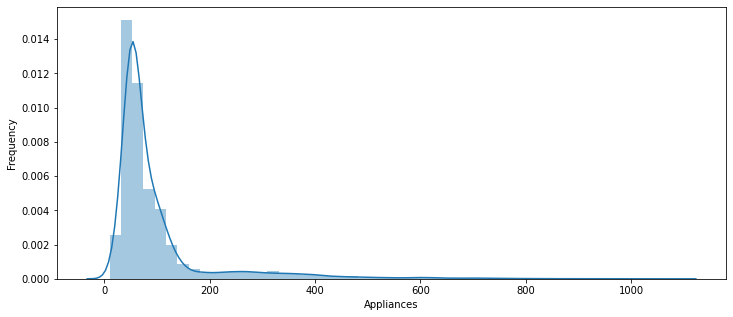

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Appliance consumption in wh')
plt.ylabel('Frequency')
sns.distplot(df['Appliances'])

<function matplotlib.pyplot.show>

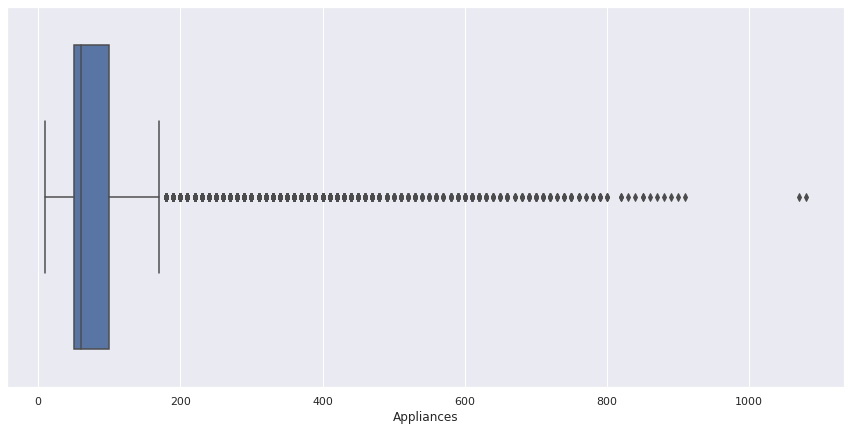

In [68]:
f, axes = plt.subplots(figsize=(15,7))
sns.boxplot(data=df, x='Appliances')
plt.show

The Appliances is positively skewed, most of the values are around mean 100Wh 

#Univariate Analysis

##Lights

In [70]:
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

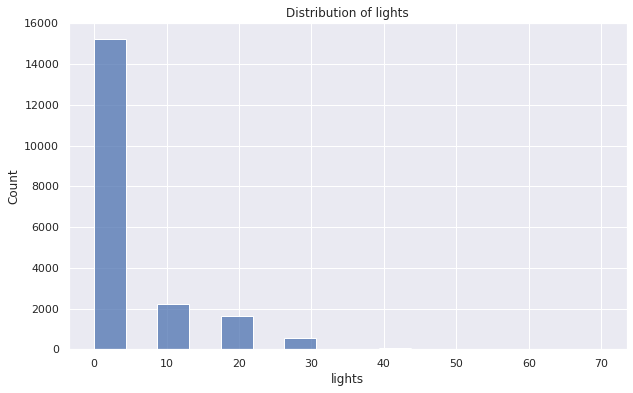

In [69]:
plt.figure(figsize = (10,6))
sns.histplot(data=df, x='lights')
plt.title(f'Distribution of lights')
plt.show()

As here we can see the number of zeros count is 15252 which means around 90% of the values are zero

Light column has 15252 entires with value = 0. It could mean there is no human presence in that room at that time; or it could be during the day where lights are not turned on; or it could be during the night when lights are turned off.

##Temperature

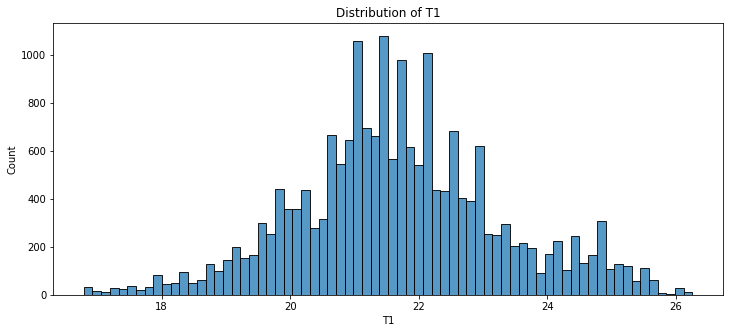

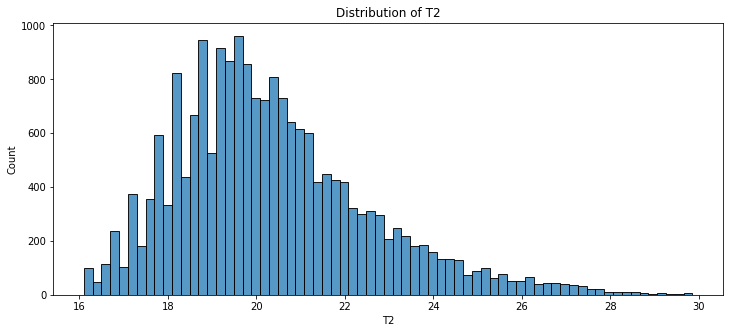

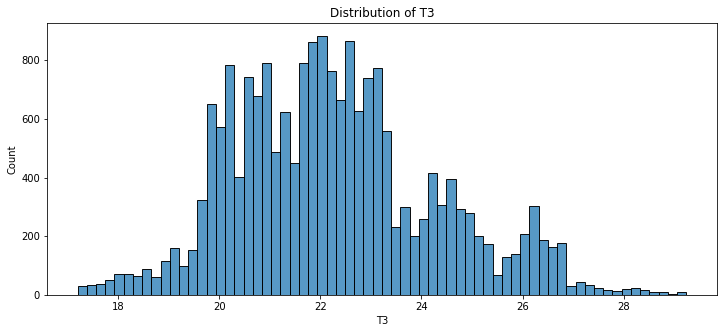

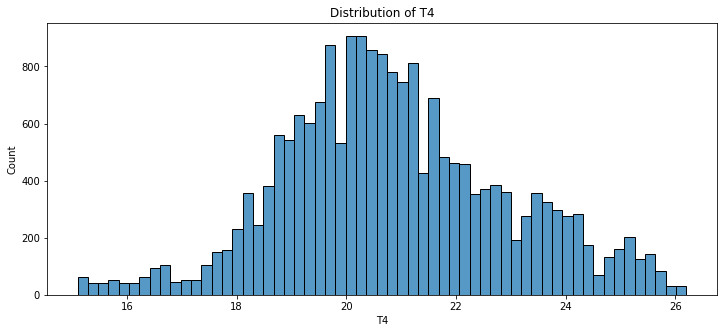

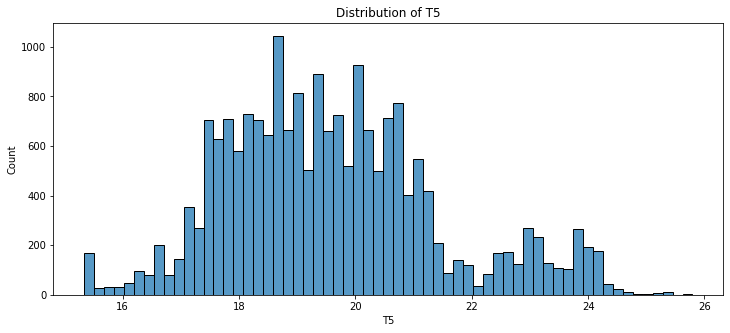

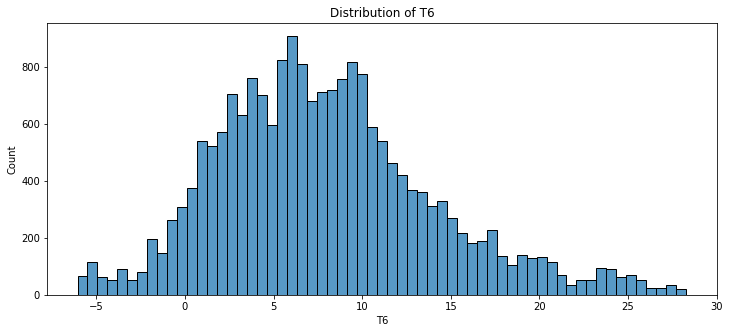

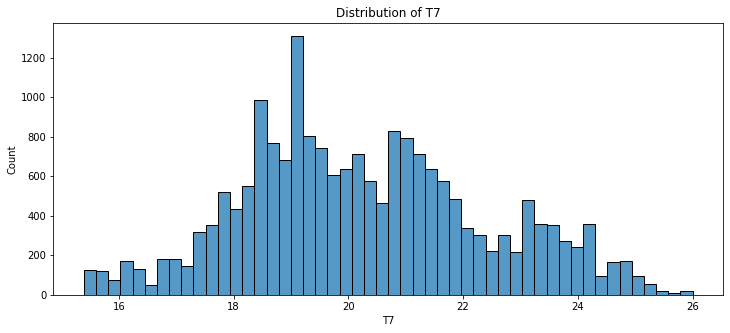

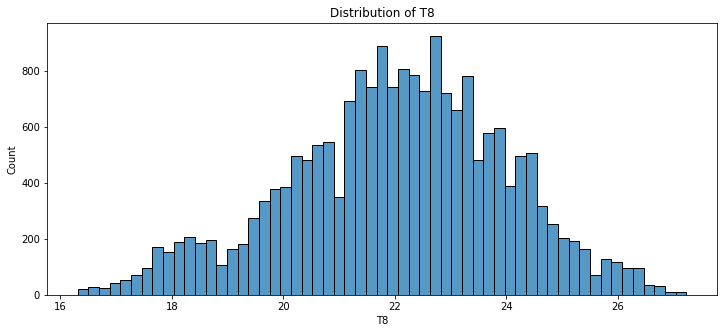

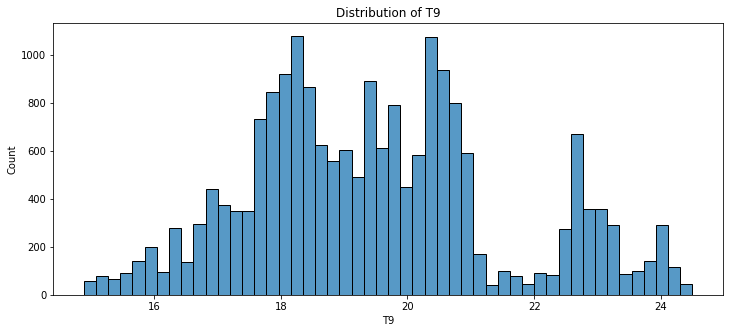

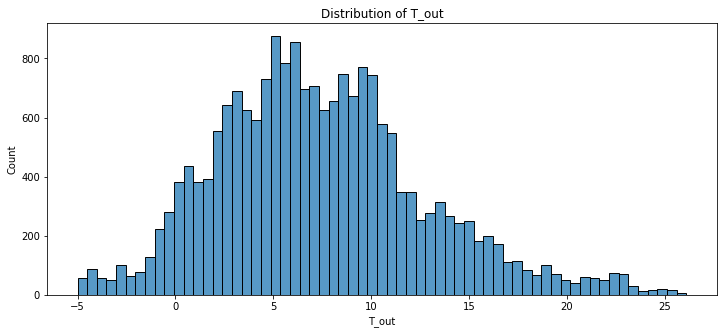

In [ ]:
for i, col in enumerate(df[temp_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

##Humidity

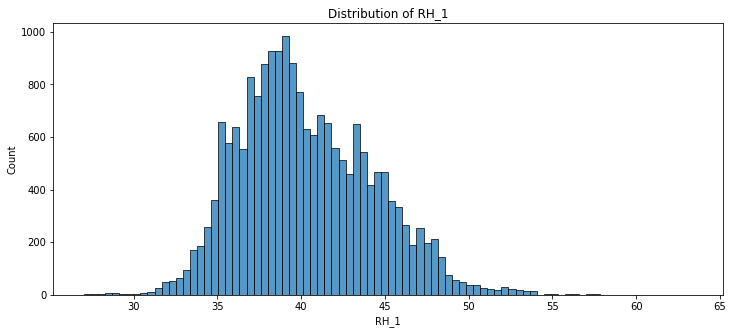

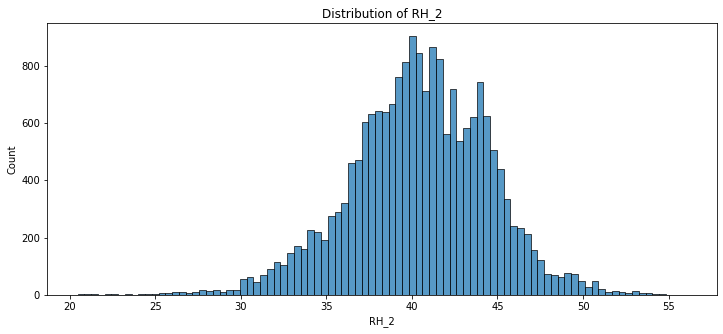

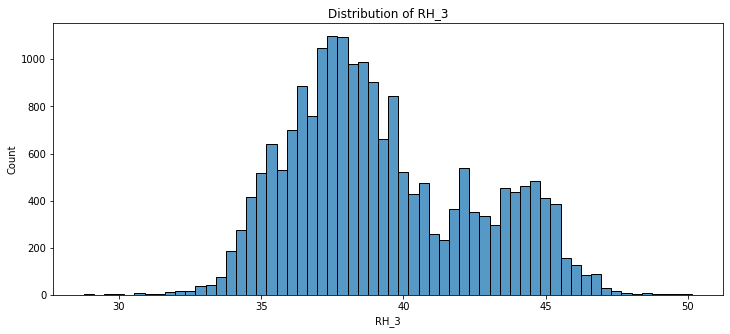

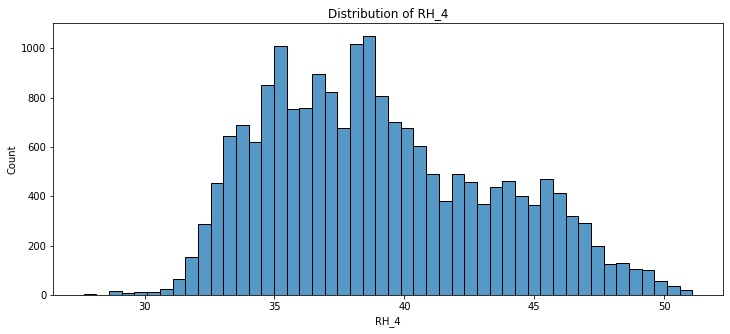

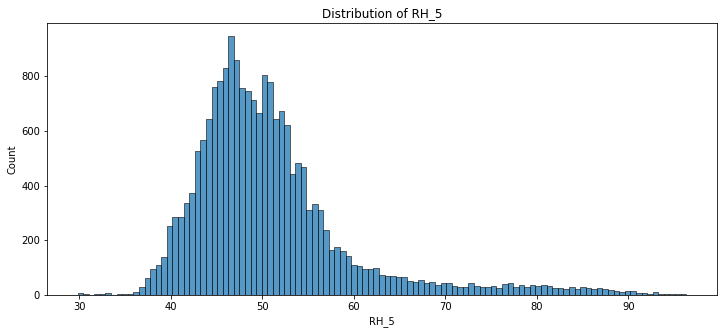

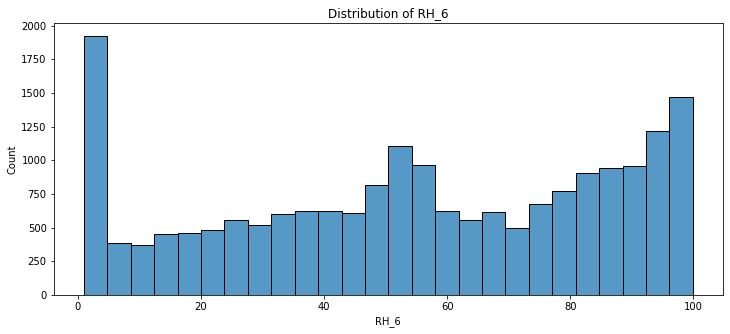

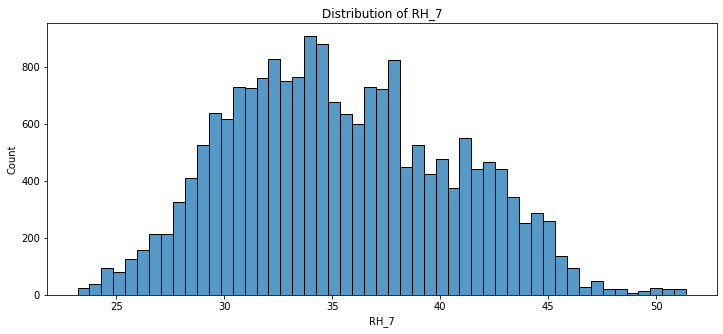

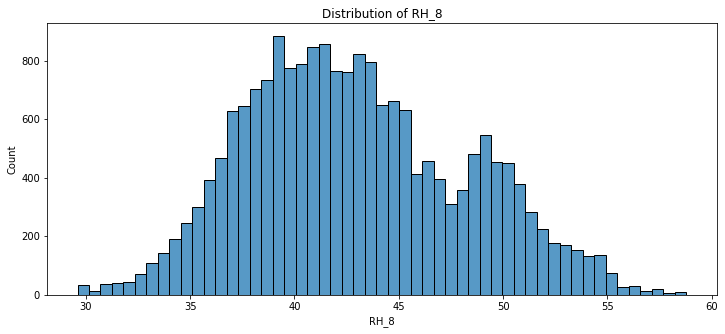

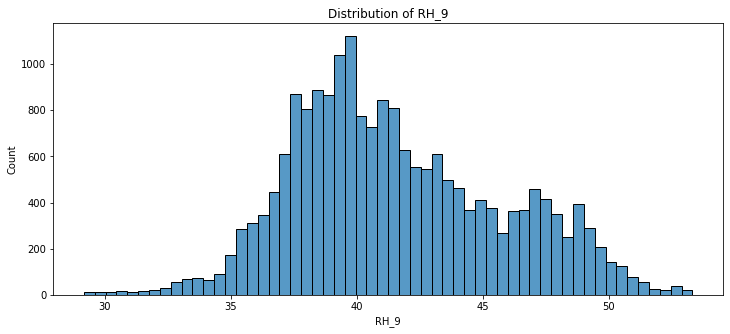

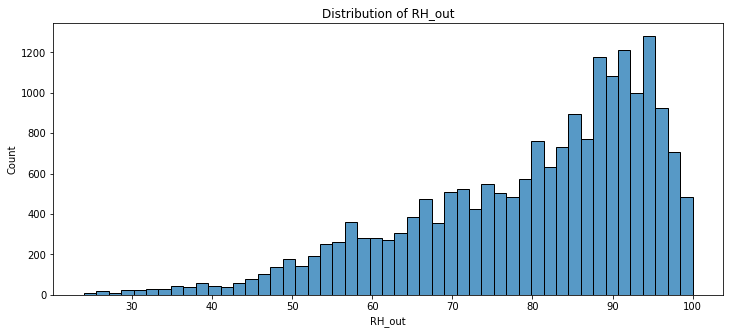

In [ ]:
for i, col in enumerate(df[humidity_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

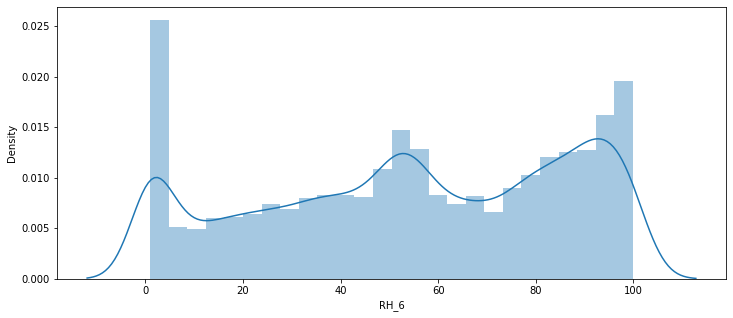

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['RH_6'])

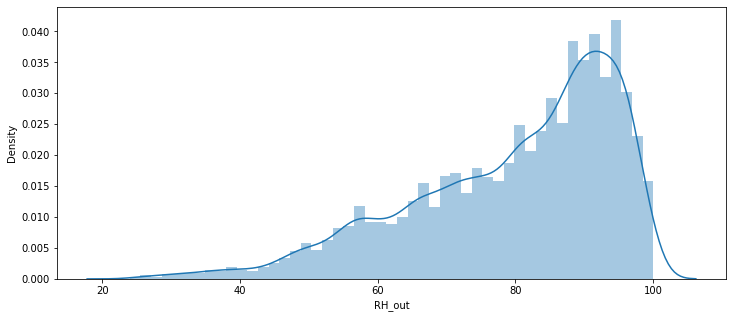

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['RH_out'])

Temperature - All the columns follow normal distribution except T9

Humidity - All columns follow normal distribution except RH_6 and RH_out, primarly because these sensors are outside the house

##Outside wheather

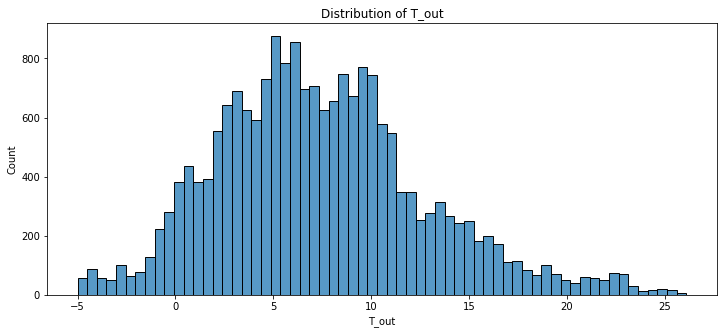

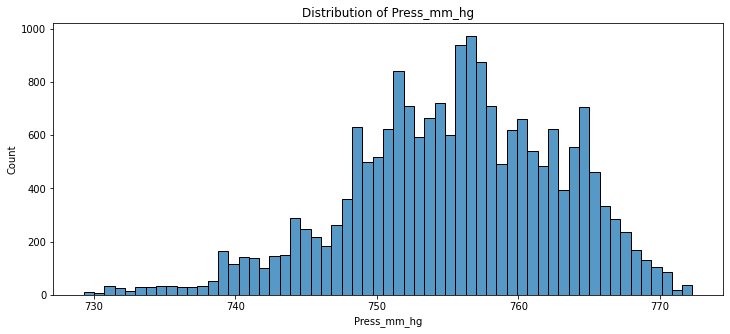

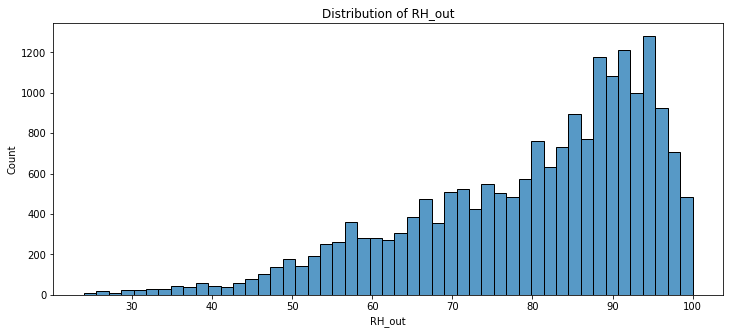

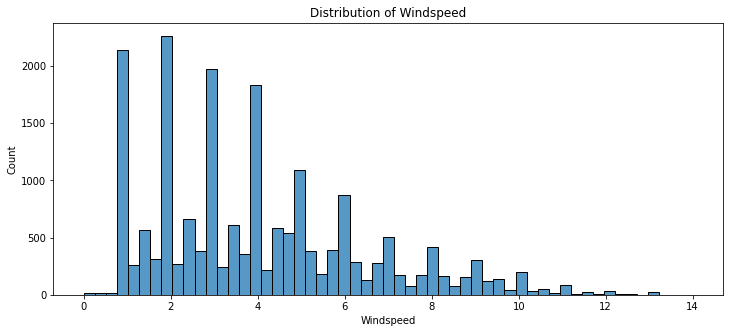

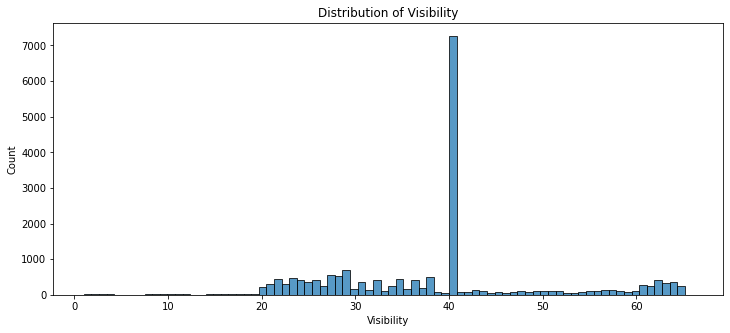

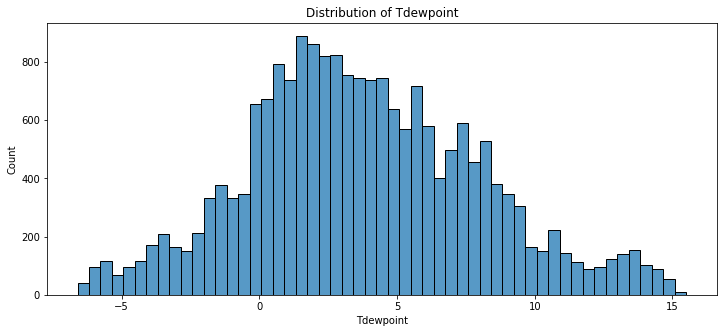

In [ ]:
for i, col in enumerate(df[weather_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

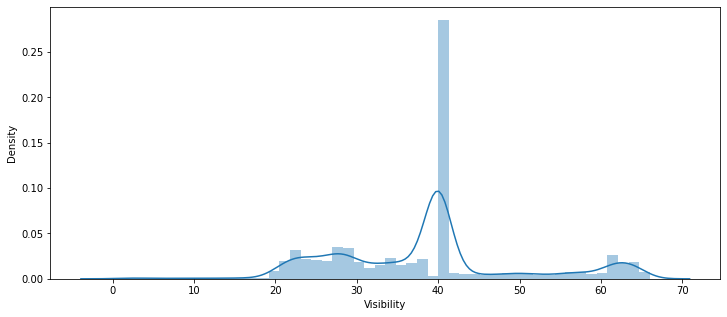

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['Visibility'])

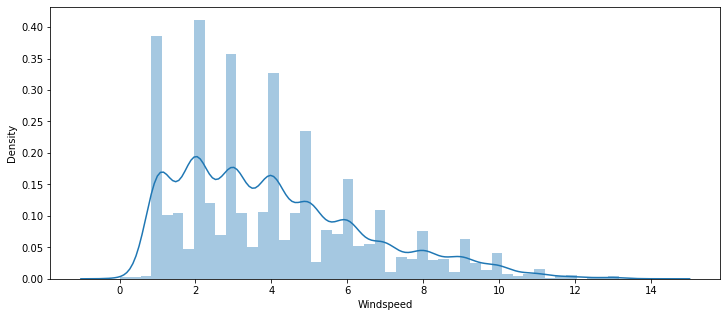

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['Windspeed'])

Visibility is negatively skewed


Windspeed is positively skewed

In [ ]:
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

As here we can see the number of zeros count is 15252 which means around 90% of the values are zero

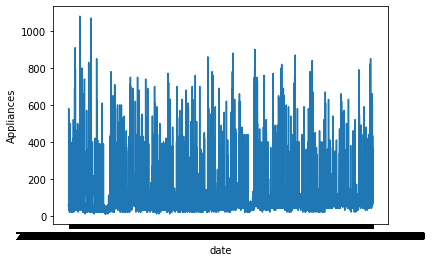

In [ ]:
sns.lineplot(df['date'],df['Appliances'])

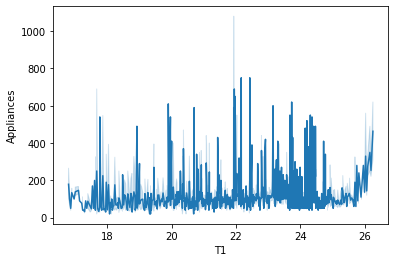

In [ ]:
sns.lineplot(df['T1'],df['Appliances'])

In [ ]:
sns.lineplot(df['date'],df['Appliances'])

##Bivariate Analysis

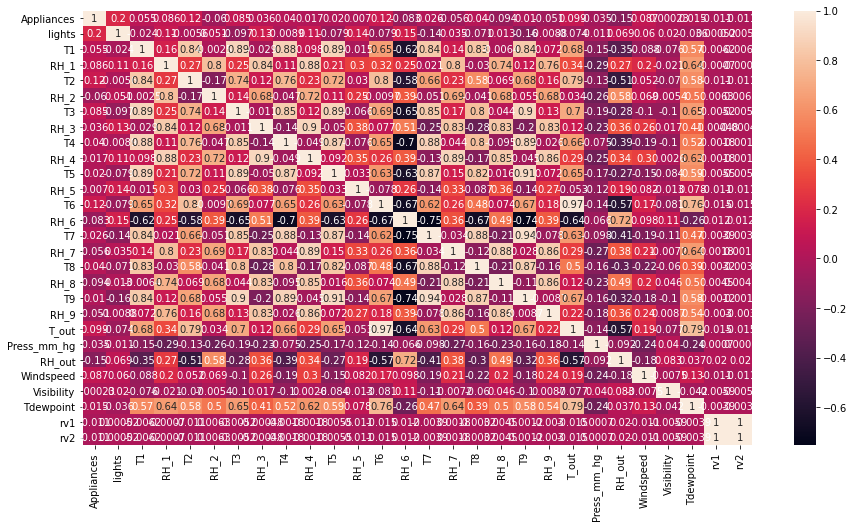

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [47]:
 import dateutil
 df["exact_date"]=df['date'].str.split(' ').str[0]

df["hours"]=(df['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
df["seconds"]=((df['date'].str.split(':').str[1])).astype(str).astype(int).mul(60)

df["week"]=(df['date'].str.split(' ').str[0])
df["week"]=(df['week'].apply(dateutil.parser.parse, dayfirst=True))
df["weekday"]=(df['week'].dt.dayofweek).astype(str).astype(int)
df["week"]=(df['week'].dt.day_name())

df['log_appliances'] = np.log(df.Appliances)
df['hour*lights'] = df.hours * df.lights
df['hour_avg'] = list(map(dict(df.groupby('hours')["Appliances"].mean()).get, df.hours))

df.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,exact_date,hours,seconds,week,weekday,log_appliances,hour*lights,hour_avg
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,2016-01-11,17,0,Tuesday,1,4.094345,510,161.352657
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,2016-01-11,17,600,Tuesday,1,4.094345,510,161.352657
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,2016-01-11,17,1200,Tuesday,1,3.912023,510,161.352657
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,2016-01-11,17,1800,Tuesday,1,3.912023,680,161.352657
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,2016-01-11,17,2400,Tuesday,1,4.094345,680,161.352657


##Hour of the day

In [51]:
# Data sets in 30 minitues and 1 hour basis
df['date']=pd.to_datetime(df['date'])
df = df.set_index('date')
df_hour = df.resample('1H').mean()
df_30min =df.resample('30min').mean()

In [52]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.
'''

df['low_consum'] = (df.Appliances+25<(df.hour_avg))*1
df['high_consum'] = (df.Appliances+100>(df.hour_avg))*1

df_hour['low_consum'] = (df_hour.Appliances+25<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.Appliances+25>(df_hour.hour_avg))*1

df_30min['low_consum'] = (df_30min.Appliances+25<(df_30min.hour_avg))*1
df_30min['high_consum'] = (df_30min.Appliances+35>(df_30min.hour_avg))*1

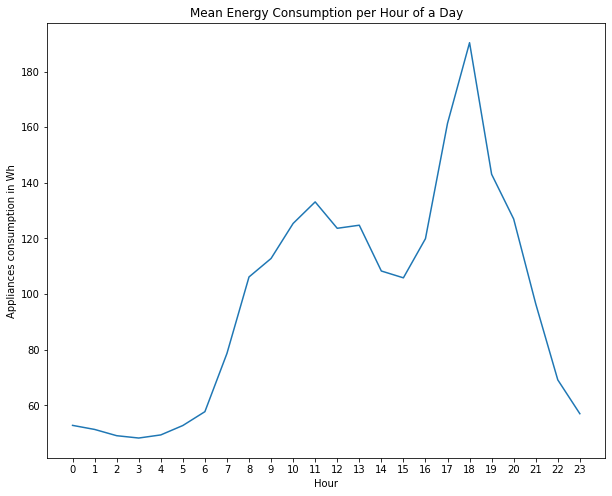

In [53]:
# Plot of Mean Energy Consumption per Hour of a Day

df.groupby('hours')['Appliances'].mean().plot(figsize=(10,8))
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks);

* During night time appliance usage is low.
* High during morning hours
* And it peaks during the evening.

Histogram of appliances consumption

Text(0.5, 0, 'Appliances log(wH)')

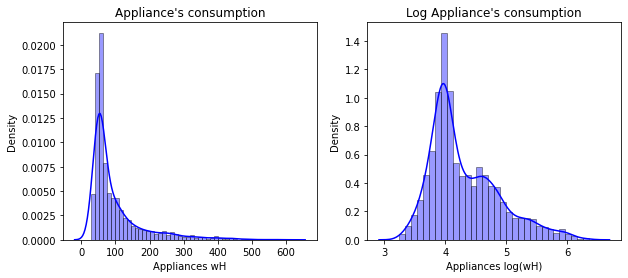

In [54]:
f, axes = plt.subplots(1, 2,figsize=(10,4))

sns.distplot(df_hour.Appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Appliance's consumption")
axes[0].set_xlabel('Appliances wH')

sns.distplot(df_hour.log_appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log Appliance's consumption")
axes[1].set_xlabel('Appliances log(wH)')

Day wise electricity consumption

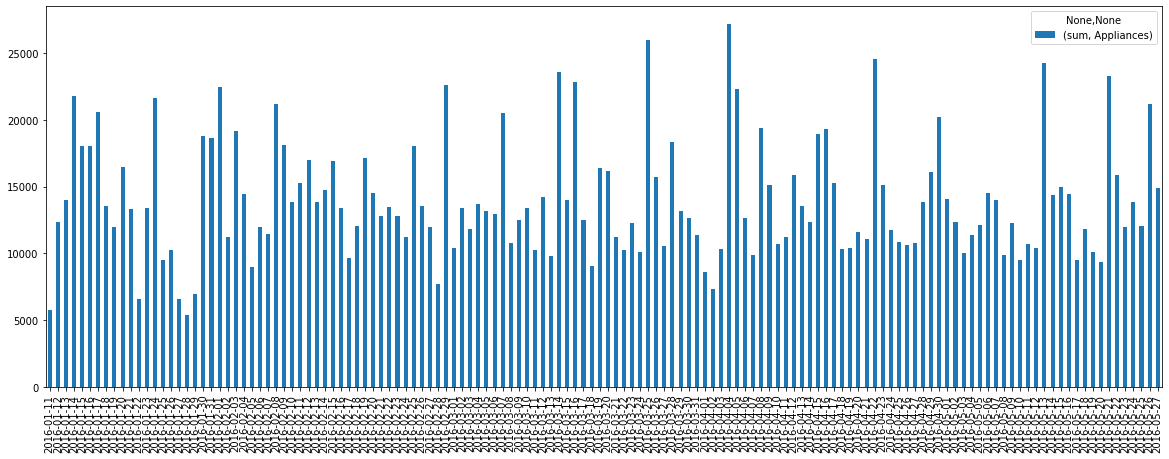

In [48]:
dates=df["exact_date"].unique()
arranged_day = pd.Categorical(df["exact_date"], categories=dates,ordered=True)
date_series = pd.Series(arranged_day)
table = pd.pivot_table(df,values="Appliances",index=date_series, aggfunc=[np.sum],fill_value=0)
table.plot(kind="bar",figsize=(20, 7))
plt.show()

Weekend Vs Weekday

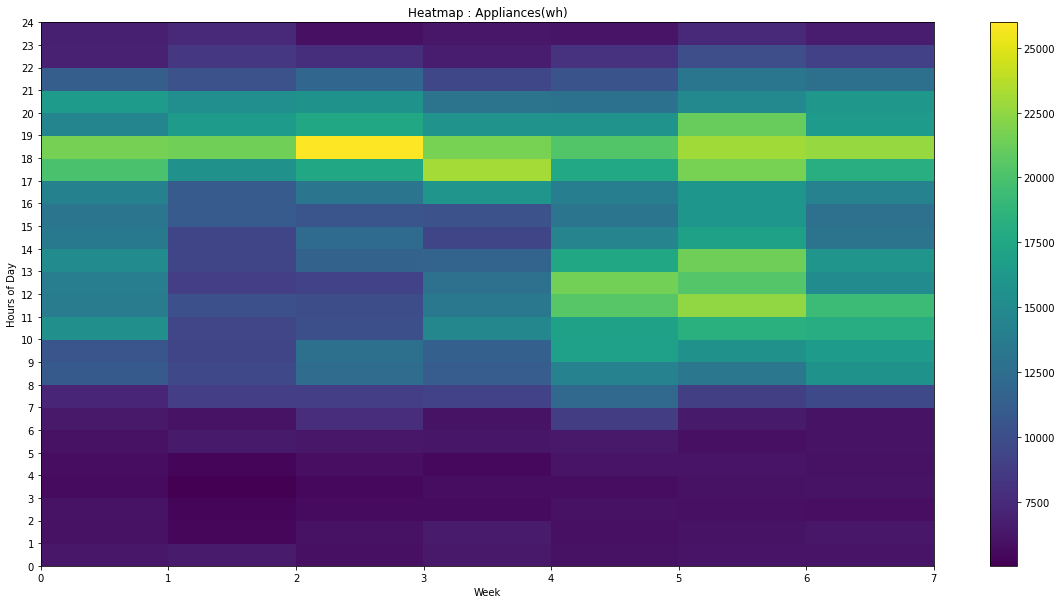

In [49]:
days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
arranged_day = pd.Categorical(df["week"], categories=days,ordered=True)
day_series = pd.Series(arranged_day)
table = pd.pivot_table(df,index=["hours"],
               values="Appliances",columns=day_series,
               aggfunc=[np.sum],fill_value=0)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Heatmap : Appliances(wh)')

heatmap = ax.pcolor(table)

ax.set_xlabel("Week Days")
ax.set_ylabel("Hours")

plt.colorbar(heatmap)
ax.set_yticks(range(len(table.index)+1))
ax.set_xticks(range(len(table.columns)+1))

plt.xlabel("Week")
plt.ylabel("Hours of Day")
plt.show()

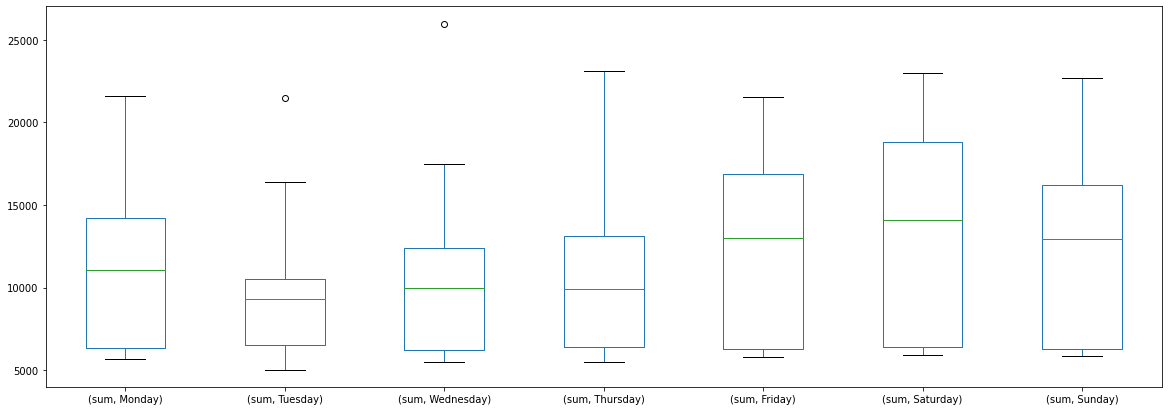

In [50]:
table.plot.box(figsize=(20, 7))

Energy consumption is high on weekends and low during the weekdays

In [71]:
# df['year']=df['date'].dt.year
# df['month']=df['date'].dt.month
# df['day']=df['date'].dt.day
# df['hour']=df['date'].dt.day
# df['dayofweek']=df['date'].dt.dayofweek

##Multivariate Analysis

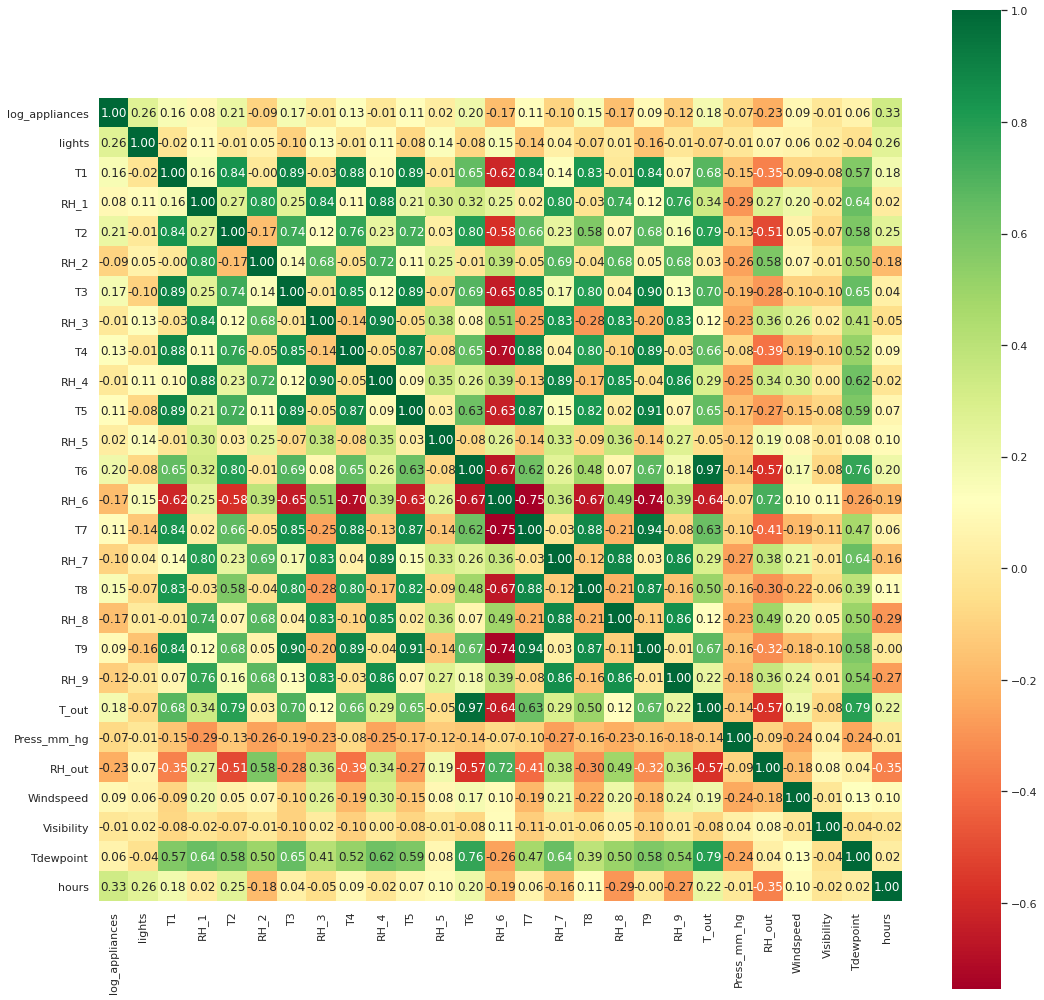

In [55]:
col = ['log_appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint','hours']
corr = df[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True,cmap="RdYlGn", fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

Tranforming categorical variables

In [58]:
for cat_feature in ['weekday', 'hours']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature])], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1)

#Modelling

In [59]:
feature_set = ['low_consum','high_consum','hours','T6','RH_6','lights','hour*lights',
               'Tdewpoint','Visibility','Press_mm_hg','Windspeed']

In [60]:
# to avoid warnings from standardscaler
df_hour.lights = df_hour.lights.astype(float)
df_hour.log_appliances = df_hour.log_appliances.astype(float)
df_hour.hour = df_hour.hours.astype(float)
df_hour.low_consum = df_hour.low_consum.astype(float)
df_hour.high_consum = df_hour.high_consum.astype(float)

In [61]:
# Creation of train/test sets
test_size=.2
test_index = int(len(df_hour.dropna())*(1-test_size))

X_train, X_test = df_hour[feature_set].iloc[:test_index,],df_hour[feature_set].iloc[test_index:,]
y_train = df_hour.log_appliances.iloc[:test_index,]

y_test =  df_hour.log_appliances.iloc[test_index:,]

In [62]:
from sklearn.preprocessing import StandardScaler

# Normalizing of X matrices for each model to mean = 0 and standard deviation = 1

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Linear Regression

In [63]:
from sklearn import linear_model

lin_model = linear_model.LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

SVR

In [64]:
from sklearn import svm

svr_model = svm.SVR(gamma='scale')
svr_model.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Randomforest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100,random_state=1)            
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

Model Evaluation, Cross validation & Selection

In [67]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Function to evaluate the models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - mape
    print(model,'\n')
    print('Average Error       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy))

In [68]:
evaluate(lin_model, X_test, y_test)
evaluate(svr_model, X_test, y_test)
evaluate(rf_model, X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

Average Error       : 0.3170 degrees
Variance score R^2  : 22.91%
Accuracy            : 92.76%

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Average Error       : 0.2740 degrees
Variance score R^2  : 35.22%
Accuracy            : 94.04%

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False) 

Average Error       : 0.2092 degrees
Variance score R^2  : 64.85%
Accuracy     

In [69]:
cv = TimeSeriesSplit(n_splits = 10)

print('Linear Model:')
scores = cross_val_score(lin_model, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(lin_model, X_train, y_train, cv=cv,scoring='r2')
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

print('SVR Model:')
scores = cross_val_score(svr_model, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(svr_model, X_train, y_train, cv=cv)
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

print('Random Forest Model:')
scores = cross_val_score(rf_model, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(rf_model, X_train, y_train, cv=cv)
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

Linear Model:
Accuracy: 99.63 (+/- 0.16) degrees
R^2: 0.25 (+/- 0.26) degrees
SVR Model:
Accuracy: 99.69 (+/- 0.10) degrees
R^2: 0.48 (+/- 0.17) degrees
Random Forest Model:
Accuracy: 99.72 (+/- 0.21) degrees
R^2: 0.55 (+/- 0.45) degrees


#Model performance on test data

In [70]:
y1_pred = lin_model.predict(X_test)
y2_pred = svr_model.predict(X_test)
y3_pred = rf_model.predict(X_test)

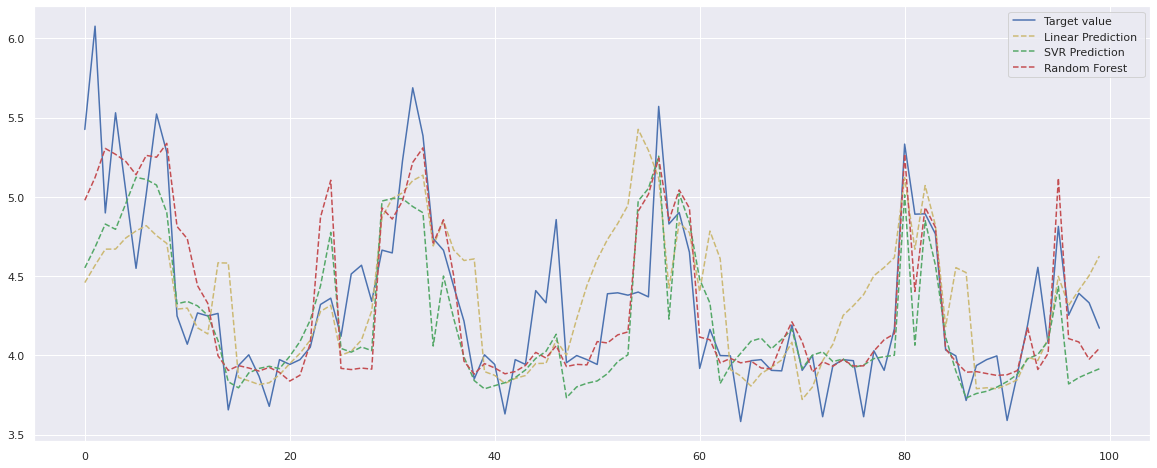

In [71]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:100].values,label='Target value',color='b')
plt.plot(y1_pred[:100],label='Linear Prediction ', linestyle='--', color='y')
plt.plot(y2_pred[:100],label='SVR Prediction ', linestyle='--', color='g')
plt.plot(y3_pred[:100],label='Random Forest', linestyle='--', color='r')
plt.legend(loc=1)

#Parameter Tuning

In [72]:
from sklearn.model_selection import GridSearchCV, KFold

parameters = {
    'max_depth': [800,1000,1500],
    'min_samples_leaf': [5,8,10],
    'min_samples_split': [5,10,15],
    'n_estimators': [40,60,100],
    'random_state':[1]    
}

cv =cv
grid_model = GridSearchCV(RandomForestRegressor(), parameters, cv=cv)

grid_model = grid_model.fit(X_train, y_train)
print(grid_model.best_estimator_)
print(grid_model.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=800, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)
{'max_depth': 800, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 60, 'random_state': 1}


In [73]:
best_rf_model = grid_model.best_estimator_
grid_accuracy = evaluate(grid_model, X_test, y_test)
y_best_pred = best_rf_model.predict(X_test)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

The Variance score of the model impoved from 65% to 68.19%.¶


Final predictions on test set based on best RF model

In [74]:
# Calculate Confidence interval 95% for the predictions
sum_errs = np.sum((y_test - y_best_pred)**2)
stdev = np.sqrt(1/(len(df_hour)-2) * sum_errs)

interval = 1.96 * stdev #95% CI
lower, upper = y_best_pred - interval, y_best_pred + interval

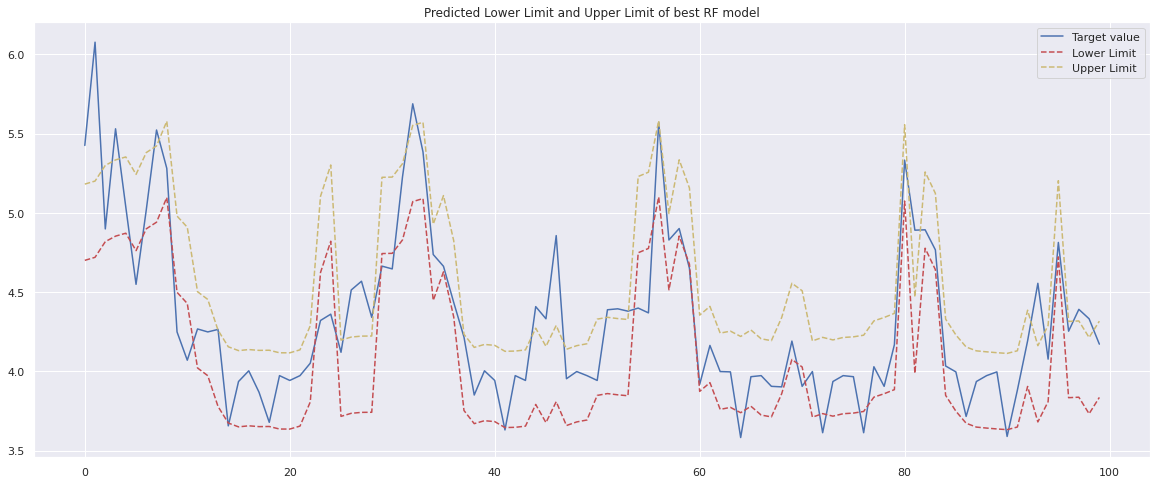

In [75]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:100].values,label='Target value',color='b')
#plt.plot(y_pred,label='Best Tree Prediction ', linestyle='-', color='b')
plt.plot(lower[:100],label='Lower Limit ', linestyle='--', color='r')
plt.plot(upper[:100],label='Upper Limit ', linestyle='--', color='y')
plt.title('Predicted Lower Limit and Upper Limit of best RF model')

plt.legend(loc=1)

#Factors influencing energy consumption


In [76]:
factor_list = feature_set
factors = np.array(X_test)

importances = list(rf_model.feature_importances_)

factor_importances = [(factor, round(importance, 2)) 
    for factor, importance in zip(factor_list, importances)]

factor_importances = sorted(factor_importances, key = lambda X_test: X_test[1], reverse = True)
 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in factor_importances];


Variable: hours                Importance: 0.47
Variable: high_consum          Importance: 0.18
Variable: low_consum           Importance: 0.06
Variable: RH_6                 Importance: 0.06
Variable: Press_mm_hg          Importance: 0.05
Variable: T6                   Importance: 0.04
Variable: hour*lights          Importance: 0.04
Variable: Tdewpoint            Importance: 0.04
Variable: Visibility           Importance: 0.03
Variable: Windspeed            Importance: 0.03
Variable: lights               Importance: 0.01


Text(0.5, 1.0, 'Factors influencing energy consumption')

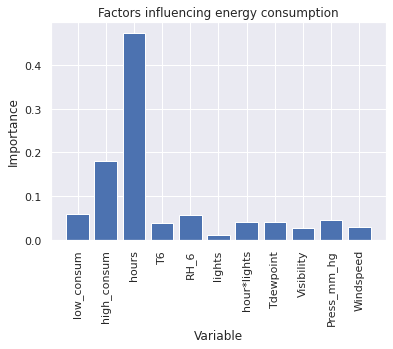

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, factor_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable')
plt.title('Factors influencing energy consumption')

Hour of the Day is the important influencing parameter for Energy consumption.


##Using different features lets see what results we get

Extracting date time features from the date column

In [79]:
df['date_1'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['exact_date'] = df['date_1'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
df['day_name'] = df['date_1'].apply(lambda x: datetime.strftime(x, '%A'))
df['day_num'] = df['date_1'].apply(lambda x: datetime.strftime(x, '%w'))
df['hour']=(df['date'].str.split(' ').str[1].str.split(':').str[0]).astype(int)
df['week_status'] = np.where((df['day_name']=='Saturday') | (df['day_name']=='Sunday'), 'Weekend', 'Weekday' )

Next we can create average , temp and avg hum for indoor humidity and temperature

In [80]:
df['avg_temp']=0
for i in temp_col:
  df['avg_temp']=df['avg_temp']+df[i]
df['avg_temp']=df['avg_temp']/len(temp_col)

df['avg_hum']=0
for i in humidity_col:
  df['avg_hum']=df['avg_hum']+df[i]
df['avg_hum']=df['avg_hum']/len(temp_col)

Removing outliers

In [81]:
T=df[['Appliances']]
Q1 = T.quantile(0.25)
Q3 = T.quantile(0.75)
IQR = Q3 - Q1
print("Outlier threshold of Appliances ",IQR)

dfOutlier=T.describe()
outlierSet=set()
for column in dfOutlier.columns:
    Q1 = dfOutlier[column]['25%']
    Q3 = dfOutlier[column]['75%']
    IQR = Q3 - Q1
    outlierDf= ( ((T[column] < (Q1 - 1.5 * IQR)) |(T[column] > (Q3 + 1.5 * IQR))) )
    outlierSet.update(set(outlierDf[outlierDf==True].index))
        

df.drop(outlierSet, inplace=True, axis=0)

Outlier threshold of Appliances  Appliances    50.0
dtype: float64


In [82]:
print(f'After removing Outliers {df.shape}')

After removing Outliers (17597, 37)


Train test split

In [83]:
X = df.drop(['Appliances','date', 'date_1', 'exact_date', 'day_num', 'week_status'],axis=1)
y = df['Appliances']

Creat dummi values

In [84]:
X = pd.get_dummies(X, columns=['day_name'], drop_first=True)

Train test split

In [85]:
# spliting the Data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Scaling the data

In [86]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Modeling

In [87]:
lr = LinearRegression()
ridge = Ridge(random_state=0)
svm = SVR(kernel='rbf')
rf = RandomForestRegressor(random_state=0)
gbr = GradientBoostingRegressor(random_state=0)
# xgbr = XGBRegressor(objective='reg:squarederror', random_state=0)

models = [lr, ridge, svm, rf, gbr]

In [88]:
def score_model(X_train,y_train,X_test,y_test):
    df_columns=[]
    df=pd.DataFrame(columns=df_columns)
    i=0

    y_train_trans=np.log10(y_train)

       
    #read model one by one
    for model in models:
        model.random_state=0
        model.fit(X_train,y_train_trans)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)      
               
        #insert in dataframe
        df.loc[i,"Model_Name"]=model.__class__.__name__
              
        df.loc[i,'Train RMSE'] = sqrt(mean_squared_error( (y_train), 10**(train_pred) ) )
        df.loc[i,'Test RMSE'] = sqrt(mean_squared_error( (y_test), 10**(test_pred) ) )
        df.loc[i,'Train R2'] = metrics.r2_score( (y_train), 10**(train_pred) )
        df.loc[i,'Test R2'] = metrics.r2_score( (y_test), 10**(test_pred) )
        
        i+=1

    return(df)

In [89]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
scores_baseline = score_model(X_train,y_train,X_test,y_test)
scores_baseline

,Model_Name,Train RMSE,Test RMSE,Train R2,Test R2
0,LinearRegression,22.961838,23.492679,0.347229,0.326118
1,Ridge,22.962343,23.492439,0.347200,0.326132
2,SVR,16.216599,18.934329,0.674413,0.562258
3,RandomForestRegressor,6.515818,16.369365,0.947436,0.672823
4,GradientBoostingRegressor,18.776773,19.982553,0.563495,0.512448


Checking Feature Importance Based on Random Forest

Text(0.5, 0, 'Relative Importance')

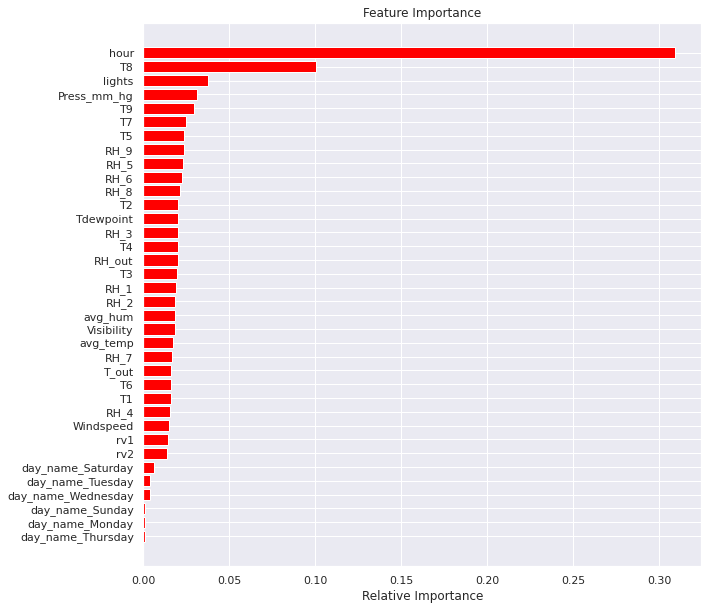

In [90]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [91]:
X = df.drop(['date', 'Appliances', 'rv1', 'rv2', 'date_1', 'exact_date', 'day_name', 'day_num', 'week_status',
               'T_out', 'Visibility', 'Windspeed', 'avg_temp', 'avg_hum'
               ], axis=1)

Hyper Parameter Tuning

In [92]:
# Define function for training model

def build_model(model, param_dict, xtrain, ytrain):

  grid = RandomizedSearchCV(estimator=model,
                       param_distributions = param_dict,
                       cv = 5, verbose=2, scoring='neg_mean_squared_error', n_jobs=5)
  
  y_train_trans=np.log10(ytrain)

  grid.fit(xtrain, y_train_trans)
  optimal_model = grid.best_estimator_

  return optimal_model

Fitting model using selected features

In [93]:
X_fet=df.drop(['Appliances','day_name', 'day_num', 'date_1', 'exact_date', 'week_status', 'rv1','rv2','T1','Visibility','T3','T_out','T6','RH_4','avg_temp','Windspeed','avg_hum','RH_7','T2',
           'T5','date','RH_1','RH_2','RH_8','RH_5','RH_6','T4','RH_out','RH_3','Tdewpoint'],axis=1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [96]:
models = [lr, ridge, svm, rf, gbr]
scores_baseline_3 = score_model(X_train,y_train,X_test,y_test)
scores_baseline_3

,Model_Name,Train RMSE,Test RMSE,Train R2,Test R2
0,LinearRegression,23.092101,23.628237,0.339802,0.318319
1,Ridge,23.092067,23.627664,0.339804,0.318352
2,SVR,16.889243,18.885483,0.646843,0.564513
3,RandomForestRegressor,6.482356,16.337665,0.947975,0.674089
4,GradientBoostingRegressor,18.929761,20.078029,0.556353,0.507778


here we see that we didnt get changed in the scores as previous with base models we get